In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imutils import paths
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from skimage.transform import resize
from skimage import io, color
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
# Define the target width and height for resizing
width, height = 256, 256

# Define the directories for benign and malignant images
benign_dir = '/content/drive/MyDrive/BreastCancer/processed_images/benign'
malignant_dir = '/content/drive/MyDrive/BreastCancer/processed_images/malignant'

# Load images and labels
data = []
labels = []

# Load benign images
for filename in os.listdir(benign_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(benign_dir, filename)
        label = 0  # Label for benign images
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (width, height))
        # Apply image processing steps here
        data.append(resized_image)
        labels.append(label)

# Load malignant images
for filename in os.listdir(malignant_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(malignant_dir, filename)
        label = 1  # Label for malignant images
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (width, height))
        # Apply image processing steps here
        data.append(resized_image)
        labels.append(label)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Shuffle data and labels together
data, labels = shuffle(data, labels)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

unique_labels = np.unique(labels)
print("Unique labels:", unique_labels)


Data shape: (521, 256, 256, 3)
Labels shape: (521,)
Unique labels: [0 1]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


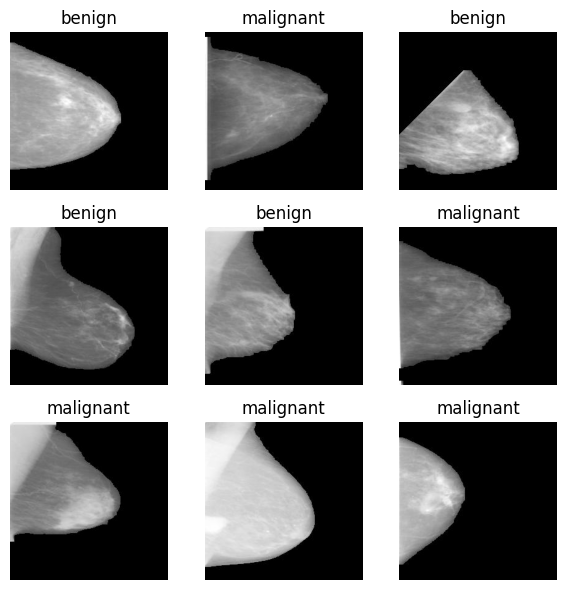

In [ ]:
import random

# Define the mapping dictionary
label_mapping = {
    0: 'benign',
    1: 'malignant'
}

# Randomly select 9 indices
indices = random.sample(range(len(data)), 9)

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

# Plot the randomly selected images along with their labels
for i, idx in enumerate(indices):
    axes[i // 3, i % 3].imshow(data[idx], cmap='gray')
    class_idx = labels[idx]
    class_name = label_mapping[class_idx]
    axes[i // 3, i % 3].set_title('{}'.format(class_name))
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.1)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (468, 256, 256, 3)
Test images: (53, 256, 256, 3)
Train label: (468,)
Test label: (53,)


## VGG16 Model


In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras import layers

Vgg16 = VGG16(include_top=False, input_shape=(256, 256, 3))

Vgg16.trainable = False

model = Sequential()
model.add(Vgg16)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])  # Change metrics to list

callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=20, restore_best_weights=True)]

# Train your model using y_train and validate using y_test
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test), verbose=1, callbacks=callbacks)

Epoch 1/15
8/8 [==============================] - 484s 61s/step - loss: 4.7790 - binary_accuracy: 0.4551 - val_loss: 1.5075 - val_binary_accuracy: 0.5283
Epoch 2/15
8/8 [==============================] - 453s 57s/step - loss: 1.8425 - binary_accuracy: 0.5534 - val_loss: 1.3517 - val_binary_accuracy: 0.6038
Epoch 3/15
8/8 [==============================] - 447s 56s/step - loss: 1.3155 - binary_accuracy: 0.6068 - val_loss: 0.9125 - val_binary_accuracy: 0.6792
Epoch 4/15
8/8 [==============================] - 487s 61s/step - loss: 0.9975 - binary_accuracy: 0.7094 - val_loss: 1.2351 - val_binary_accuracy: 0.6415
Epoch 5/15
8/8 [==============================] - 473s 60s/step - loss: 0.8055 - binary_accuracy: 0.7393 - val_loss: 0.8445 - val_binary_accuracy: 0.6981
Epoch 6/15
8/8 [==============================] - 474s 60s/step - loss: 0.4638 - binary_accuracy: 0.8184 - val_loss: 0.8802 - val_binary_accuracy: 0.6226
Epoch 7/15
8/8 [==============================] - 471s 60s/step - loss: 0.45

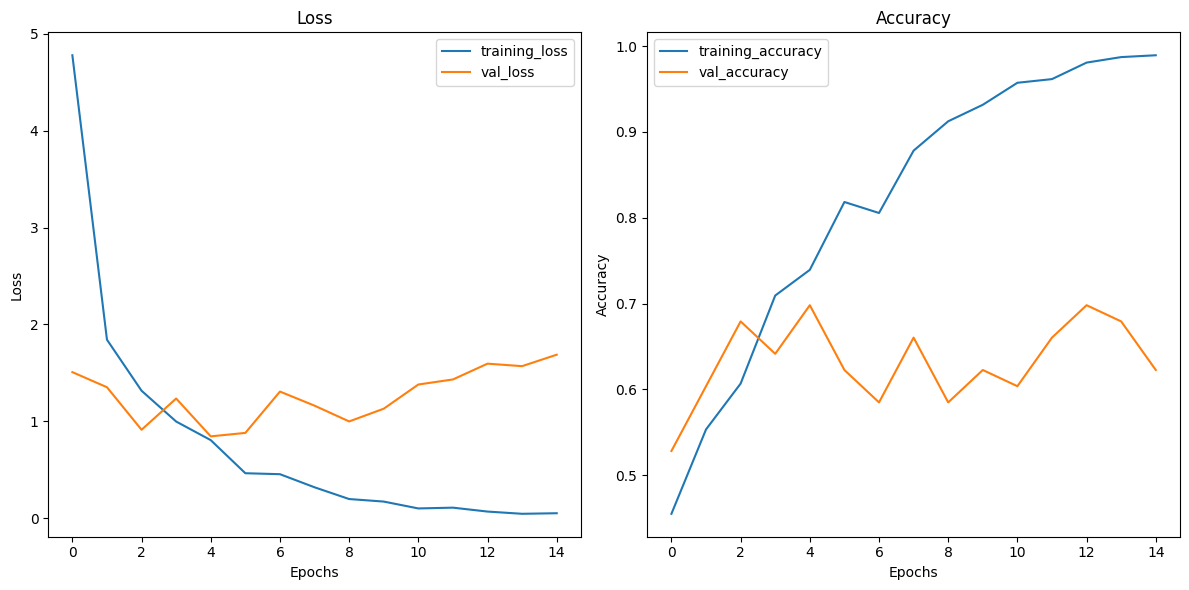

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss and accuracy curves in a single horizontal frame
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(history)

In [ ]:
# Define a function to evaluate the model
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Predictions on training, validation, and testing data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Convert predictions to class labels
    y_train_pred_classes = np.round(y_train_pred).astype(int)
    y_test_pred_classes = np.round(y_test_pred).astype(int)

    # Compute evaluation metrics
    train_accuracy = accuracy_score(y_train, y_train_pred_classes)
    test_accuracy = accuracy_score(y_test, y_test_pred_classes)

    train_precision = precision_score(y_train, y_train_pred_classes, average='weighted')
    test_precision = precision_score(y_test, y_test_pred_classes, average='weighted')

    train_recall = recall_score(y_train, y_train_pred_classes, average='weighted')
    test_recall = recall_score(y_test, y_test_pred_classes, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred_classes, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred_classes, average='weighted')

    train_conf_matrix = confusion_matrix(y_train, y_train_pred_classes)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

    # Print evaluation metrics
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)

    print("Training Precision:", train_precision)
    print("Testing Precision:", test_precision)

    print("Training Recall:", train_recall)
    print("Testing Recall:", test_recall)

    print("Training F1 Score:", train_f1)
    print("Testing F1 Score:", test_f1)

    print("Training Confusion Matrix:")
    print(train_conf_matrix)

    print("Testing Confusion Matrix:")
    print(test_conf_matrix)

# Evaluate the model
evaluate_model(model, x_train, y_train, x_test, y_test)

2/2 [==============================] - 44s 17s/step
Training Accuracy: 0.9978632478632479
Testing Accuracy: 0.6226415094339622
Training Precision: 0.9978726195831459
Testing Precision: 0.6371283369355687
Training Recall: 0.9978632478632479
Testing Recall: 0.6226415094339622
Training F1 Score: 0.9978633747864517
Testing F1 Score: 0.6149849603500137
Training Confusion Matrix:
[[227   0]
 [  1 240]]
Testing Confusion Matrix:
[[13 14]
 [ 6 20]]


In [ ]:
model.save("/content/drive/MyDrive/BreastCancer/models/vgg16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


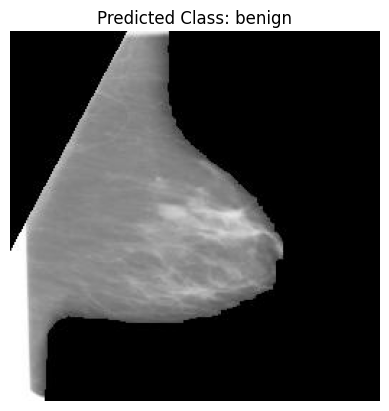

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/content/drive/MyDrive/BreastCancer/models/vgg16.h5")

# Load and preprocess the image
image_path = "/content/drive/MyDrive/BreastCancer/benign_sample.jpg"  # Replace with the path to your image
image = Image.open(image_path)
image = image.resize((256, 256))  # Resize the image to match the input size of the model
image_array = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Perform prediction
predictions = model.predict(image_array)

# Convert probabilities to class labels
predicted_class = "malignant" if predictions[0][0] > 0.5 else "benign"

# Display the image and prediction
plt.imshow(image)
plt.title("Predicted Class: " + predicted_class)
plt.axis("off")
plt.show()


## Resnet

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50  # Import ResNet50
from keras.optimizers import Adam

# Load ResNet50 with pre-trained weights and exclude the top (fully connected) layers
ResNet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers in the base ResNet model
for layer in ResNet.layers:
    layer.trainable = False

# Create your model
model = Sequential()
model.add(ResNet)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define your optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])  # Compile the model with binary crossentropy loss

# Define early stopping callback
callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]

# Train your model using x_train and y_train, and validate using x_test and y_test
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks)


94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 3.6975 - binary_accuracy: 0.5449

8/8 [==============================] - 16s 1s/step - loss: 3.6975 - binary_accuracy: 0.5449 - val_loss: 1.7217 - val_binary_accuracy: 0.5283
Epoch 2/15
8/8 [==============================] - ETA: 0s - loss: 3.2849 - binary_accuracy: 0.4829

8/8 [==============================] - 2s 229ms/step - loss: 3.2849 - binary_accuracy: 0.4829 - val_loss: 1.7786 - val_binary_accuracy: 0.3774
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 2.1553 - binary_accuracy: 0.5534

8/8 [==============================] - 2s 228ms/step - loss: 2.1553 - binary_accuracy: 0.5534 - val_loss: 1.1609 - val_binary_accuracy: 0.6226
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss: 1.5551 - binary_accuracy: 0.5662

8/8 [==============================] - 2s 231ms/step - loss: 1.5551 - binary_accuracy: 0.5662 - val_loss: 1.0866 - val_binary_accuracy: 0.5472
Epoch 5/15
8/8 [==============================] - ETA: 0s - loss: 1.1663 - binary_accuracy: 0.6261

8/8 [==============================] - 2s 230ms/step - loss: 1.1663 - binary_accuracy: 0.6261 - val_loss: 1.0474 - val_binary_accuracy: 0.5094
Epoch 6/15
8/8 [==============================] - ETA: 0s - loss: 0.9460 - binary_accuracy: 0.6325

8/8 [==============================] - 2s 233ms/step - loss: 0.9460 - binary_accuracy: 0.6325 - val_loss: 0.8579 - val_binary_accuracy: 0.5472
Epoch 7/15
8/8 [==============================] - ETA: 0s - loss: 0.7135 - binary_accuracy: 0.6987

8/8 [==============================] - 2s 231ms/step - loss: 0.7135 - binary_accuracy: 0.6987 - val_loss: 1.0804 - val_binary_accuracy: 0.5283
Epoch 8/15
8/8 [==============================] - ETA: 0s - loss: 0.6307 - binary_accuracy: 0.7051

8/8 [==============================] - 2s 234ms/step - loss: 0.6307 - binary_accuracy: 0.7051 - val_loss: 0.9606 - val_binary_accuracy: 0.6038
Epoch 9/15
8/8 [==============================] - ETA: 0s - loss: 0.5804 - binary_accuracy: 0.7457

8/8 [==============================] - 2s 233ms/step - loss: 0.5804 - binary_accuracy: 0.7457 - val_loss: 0.8719 - val_binary_accuracy: 0.5660
Epoch 10/15
8/8 [==============================] - ETA: 0s - loss: 0.4175 - binary_accuracy: 0.8162

8/8 [==============================] - 2s 236ms/step - loss: 0.4175 - binary_accuracy: 0.8162 - val_loss: 0.9820 - val_binary_accuracy: 0.5849
Epoch 11/15
8/8 [==============================] - ETA: 0s - loss: 0.3997 - binary_accuracy: 0.8056

8/8 [==============================] - 2s 239ms/step - loss: 0.3997 - binary_accuracy: 0.8056 - val_loss: 0.8801 - val_binary_accuracy: 0.5660
Epoch 12/15
8/8 [==============================] - ETA: 0s - loss: 0.3058 - binary_accuracy: 0.8654

8/8 [==============================] - 2s 239ms/step - loss: 0.3058 - binary_accuracy: 0.8654 - val_loss: 1.1090 - val_binary_accuracy: 0.5472
Epoch 13/15
8/8 [==============================] - ETA: 0s - loss: 0.2664 - binary_accuracy: 0.8846

8/8 [==============================] - 2s 242ms/step - loss: 0.2664 - binary_accuracy: 0.8846 - val_loss: 1.0606 - val_binary_accuracy: 0.5472
Epoch 14/15
8/8 [==============================] - ETA: 0s - loss: 0.1999 - binary_accuracy: 0.9316

8/8 [==============================] - 2s 245ms/step - loss: 0.1999 - binary_accuracy: 0.9316 - val_loss: 1.4253 - val_binary_accuracy: 0.5283
Epoch 15/15
8/8 [==============================] - ETA: 0s - loss: 0.1808 - binary_accuracy: 0.9487

8/8 [==============================] - 2s 246ms/step - loss: 0.1808 - binary_accuracy: 0.9487 - val_loss: 1.3264 - val_binary_accuracy: 0.5094


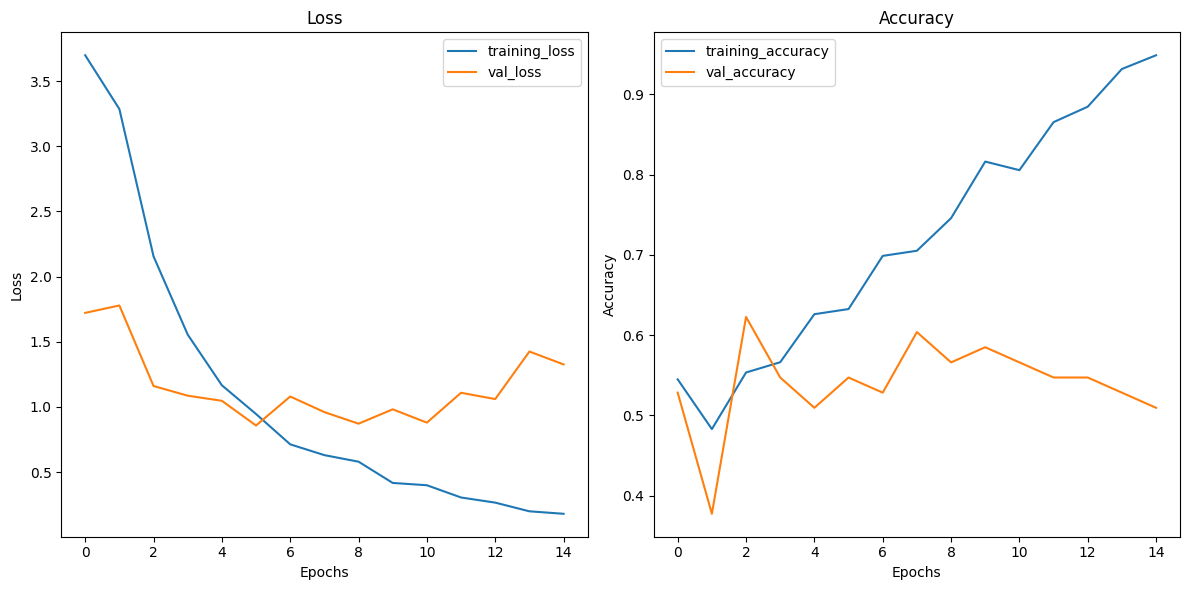

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss and accuracy curves in a single horizontal frame
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(history)

In [ ]:
# Define a function to evaluate the model
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Predictions on training, validation, and testing data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Convert predictions to class labels
    y_train_pred_classes = np.round(y_train_pred).astype(int)
    y_test_pred_classes = np.round(y_test_pred).astype(int)

    # Compute evaluation metrics
    train_accuracy = accuracy_score(y_train, y_train_pred_classes)
    test_accuracy = accuracy_score(y_test, y_test_pred_classes)

    train_precision = precision_score(y_train, y_train_pred_classes, average='weighted')
    test_precision = precision_score(y_test, y_test_pred_classes, average='weighted')

    train_recall = recall_score(y_train, y_train_pred_classes, average='weighted')
    test_recall = recall_score(y_test, y_test_pred_classes, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred_classes, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred_classes, average='weighted')

    train_conf_matrix = confusion_matrix(y_train, y_train_pred_classes)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

    # Print evaluation metrics
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)

    print("Training Precision:", train_precision)
    print("Testing Precision:", test_precision)

    print("Training Recall:", train_recall)
    print("Testing Recall:", test_recall)

    print("Training F1 Score:", train_f1)
    print("Testing F1 Score:", test_f1)

    print("Training Confusion Matrix:")
    print(train_conf_matrix)

    print("Testing Confusion Matrix:")
    print(test_conf_matrix)

# Evaluate the model
evaluate_model(model, x_train, y_train, x_test, y_test)

2/2 [==============================] - 2s 2s/step
Training Accuracy: 0.9743589743589743
Testing Accuracy: 0.5094339622641509
Training Precision: 0.9744884105377932
Testing Precision: 0.511584153093587
Training Recall: 0.9743589743589743
Testing Recall: 0.5094339622641509
Training F1 Score: 0.9743524125961474
Testing F1 Score: 0.5097833682739343
Training Confusion Matrix:
[[221   8]
 [  4 235]]
Testing Confusion Matrix:
[[13 12]
 [14 14]]


In [ ]:
model.save("/content/drive/MyDrive/BreastCancer/models/resnet50.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step


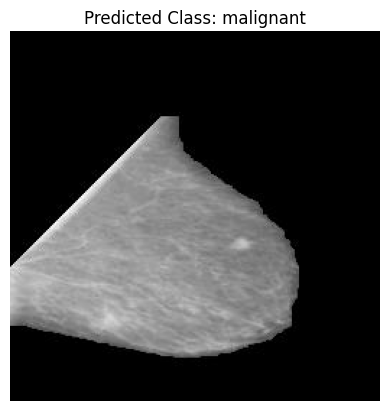

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/content/drive/MyDrive/BreastCancer/models/resnet50.h5")

# Load and preprocess the image
image_path = "/content/drive/MyDrive/BreastCancer/malignant_sample.jpg"  # Replace with the path to your image
image = Image.open(image_path)
image = image.resize((256, 256))  # Resize the image to match the input size of the model
image_array = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Perform prediction
predictions = model.predict(image_array)

# Convert probabilities to class labels
predicted_class = "malignant" if predictions[0][0] > 0.5 else "benign"

# Display the image and prediction
plt.imshow(image)
plt.title("Predicted Class: " + predicted_class)
plt.axis("off")
plt.show()


## Mobilenet Model

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.applications.mobilenet import MobileNet  # Import MobileNet
from keras.optimizers import Adam

# Load MobileNet with pre-trained weights and exclude the top (fully connected) layers
MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers in the base MobileNet model
for layer in MobileNet.layers:
    layer.trainable = False

# Create your model
model = Sequential()
model.add(MobileNet)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define your optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])  # Compile the model with binary crossentropy loss

# Define early stopping callback
callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]

# Train your model using x_train and y_train, and validate using x_test and y_test
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks)


17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 3.3117 - binary_accuracy: 0.4893

8/8 [==============================] - 7s 454ms/step - loss: 3.3117 - binary_accuracy: 0.4893 - val_loss: 4.1957 - val_binary_accuracy: 0.5283
Epoch 2/15
7/8 [=========================>....] - ETA: 0s - loss: 2.9614 - binary_accuracy: 0.5067

8/8 [==============================] - 1s 85ms/step - loss: 2.9008 - binary_accuracy: 0.5128 - val_loss: 2.6884 - val_binary_accuracy: 0.5283
Epoch 3/15
7/8 [=========================>....] - ETA: 0s - loss: 1.9488 - binary_accuracy: 0.5491

8/8 [==============================] - 1s 85ms/step - loss: 1.9656 - binary_accuracy: 0.5470 - val_loss: 1.8860 - val_binary_accuracy: 0.5094
Epoch 4/15
7/8 [=========================>....] - ETA: 0s - loss: 1.4676 - binary_accuracy: 0.5915

8/8 [==============================] - 1s 85ms/step - loss: 1.4707 - binary_accuracy: 0.5897 - val_loss: 2.0418 - val_binary_accuracy: 0.5094
Epoch 5/15
7/8 [=========================>....] - ETA: 0s - loss: 1.1404 - binary_accuracy: 0.6161

8/8 [==============================] - 1s 85ms/step - loss: 1.1483 - binary_accuracy: 0.6068 - val_loss: 1.1081 - val_binary_accuracy: 0.4906
Epoch 6/15
7/8 [=========================>....] - ETA: 0s - loss: 0.8618 - binary_accuracy: 0.6228

8/8 [==============================] - 1s 86ms/step - loss: 0.8673 - binary_accuracy: 0.6218 - val_loss: 1.0063 - val_binary_accuracy: 0.5283
Epoch 7/15
7/8 [=========================>....] - ETA: 0s - loss: 0.7495 - binary_accuracy: 0.6652

8/8 [==============================] - 1s 87ms/step - loss: 0.7488 - binary_accuracy: 0.6667 - val_loss: 1.0814 - val_binary_accuracy: 0.4906
Epoch 8/15
7/8 [=========================>....] - ETA: 0s - loss: 0.6336 - binary_accuracy: 0.7165

8/8 [==============================] - 1s 86ms/step - loss: 0.6220 - binary_accuracy: 0.7201 - val_loss: 1.4019 - val_binary_accuracy: 0.4717
Epoch 9/15
7/8 [=========================>....] - ETA: 0s - loss: 0.5642 - binary_accuracy: 0.7344

8/8 [==============================] - 1s 86ms/step - loss: 0.5584 - binary_accuracy: 0.7350 - val_loss: 1.1208 - val_binary_accuracy: 0.5094
Epoch 10/15
7/8 [=========================>....] - ETA: 0s - loss: 0.5024 - binary_accuracy: 0.7812

8/8 [==============================] - 1s 86ms/step - loss: 0.5086 - binary_accuracy: 0.7778 - val_loss: 1.1193 - val_binary_accuracy: 0.5094
Epoch 11/15
7/8 [=========================>....] - ETA: 0s - loss: 0.4145 - binary_accuracy: 0.8192

8/8 [==============================] - 1s 85ms/step - loss: 0.4186 - binary_accuracy: 0.8162 - val_loss: 1.0536 - val_binary_accuracy: 0.5472
Epoch 12/15
7/8 [=========================>....] - ETA: 0s - loss: 0.3195 - binary_accuracy: 0.8638

8/8 [==============================] - 1s 86ms/step - loss: 0.3163 - binary_accuracy: 0.8654 - val_loss: 1.2804 - val_binary_accuracy: 0.5283
Epoch 13/15
7/8 [=========================>....] - ETA: 0s - loss: 0.2511 - binary_accuracy: 0.9040

8/8 [==============================] - 1s 86ms/step - loss: 0.2635 - binary_accuracy: 0.9017 - val_loss: 1.2324 - val_binary_accuracy: 0.6226
Epoch 14/15
7/8 [=========================>....] - ETA: 0s - loss: 0.2092 - binary_accuracy: 0.9174

8/8 [==============================] - 1s 85ms/step - loss: 0.2034 - binary_accuracy: 0.9188 - val_loss: 1.8547 - val_binary_accuracy: 0.5283
Epoch 15/15
7/8 [=========================>....] - ETA: 0s - loss: 0.2373 - binary_accuracy: 0.9018

8/8 [==============================] - 1s 86ms/step - loss: 0.2385 - binary_accuracy: 0.8996 - val_loss: 1.2445 - val_binary_accuracy: 0.6038


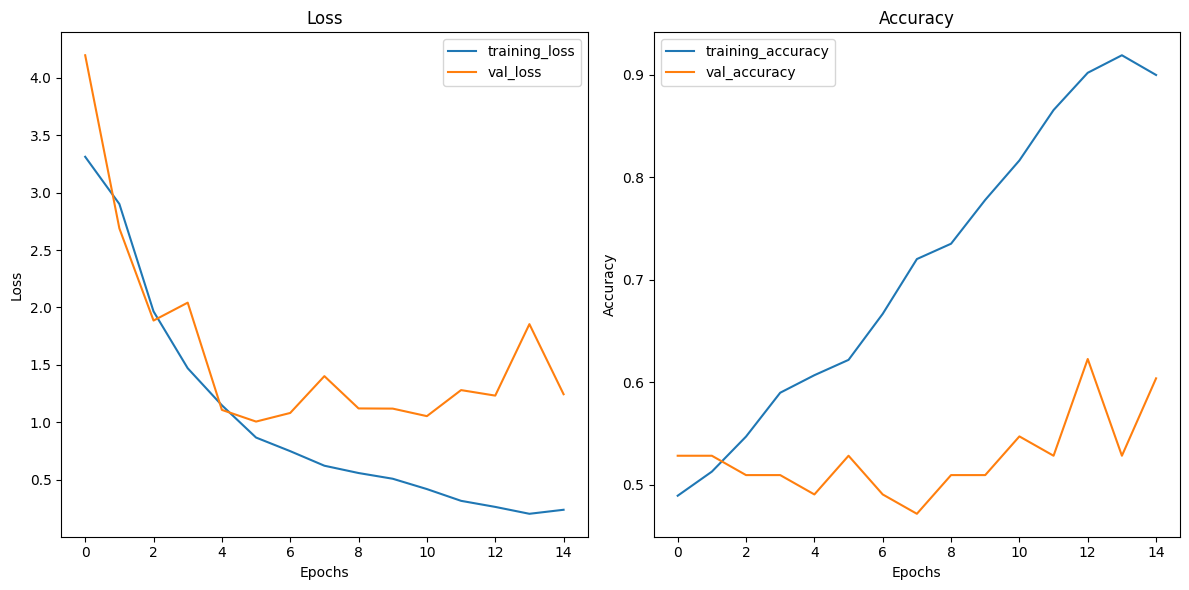

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss and accuracy curves in a single horizontal frame
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(history)

In [ ]:
# Define a function to evaluate the model
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Predictions on training, validation, and testing data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Convert predictions to class labels
    y_train_pred_classes = np.round(y_train_pred).astype(int)
    y_test_pred_classes = np.round(y_test_pred).astype(int)

    # Compute evaluation metrics
    train_accuracy = accuracy_score(y_train, y_train_pred_classes)
    test_accuracy = accuracy_score(y_test, y_test_pred_classes)

    train_precision = precision_score(y_train, y_train_pred_classes, average='weighted')
    test_precision = precision_score(y_test, y_test_pred_classes, average='weighted')

    train_recall = recall_score(y_train, y_train_pred_classes, average='weighted')
    test_recall = recall_score(y_test, y_test_pred_classes, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred_classes, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred_classes, average='weighted')

    train_conf_matrix = confusion_matrix(y_train, y_train_pred_classes)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

    # Print evaluation metrics
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)

    print("Training Precision:", train_precision)
    print("Testing Precision:", test_precision)

    print("Training Recall:", train_recall)
    print("Testing Recall:", test_recall)

    print("Training F1 Score:", train_f1)
    print("Testing F1 Score:", test_f1)

    print("Training Confusion Matrix:")
    print(train_conf_matrix)

    print("Testing Confusion Matrix:")
    print(test_conf_matrix)

# Evaluate the model
evaluate_model(model, x_train, y_train, x_test, y_test)

2/2 [==============================] - 1s 854ms/step
Training Accuracy: 0.8995726495726496
Testing Accuracy: 0.6037735849056604
Training Precision: 0.9051896556502983
Testing Precision: 0.6175314465408804
Training Recall: 0.8995726495726496
Testing Recall: 0.6037735849056604
Training F1 Score: 0.8993619098472002
Testing F1 Score: 0.5998013902681232
Training Confusion Matrix:
[[219  10]
 [ 37 202]]
Testing Confusion Matrix:
[[18  7]
 [14 14]]


In [ ]:
model.save("/content/drive/MyDrive/BreastCancer/models/mobilenet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 836ms/step


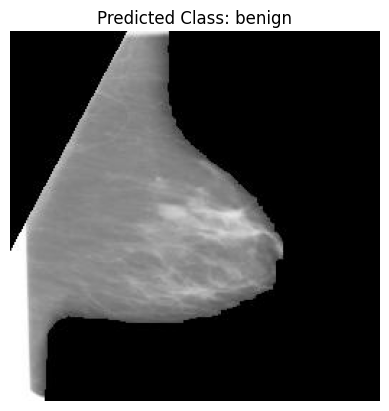

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/content/drive/MyDrive/BreastCancer/models/mobilenet.h5")

# Load and preprocess the image
image_path = "/content/drive/MyDrive/BreastCancer/benign_sample.jpg"  # Replace with the path to your image
image = Image.open(image_path)
image = image.resize((256, 256))  # Resize the image to match the input size of the model
image_array = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Perform prediction
predictions = model.predict(image_array)

# Convert probabilities to class labels
predicted_class = "malignant" if predictions[0][0] > 0.5 else "benign"

# Display the image and prediction
plt.imshow(image)
plt.title("Predicted Class: " + predicted_class)
plt.axis("off")
plt.show()


CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Define your model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define your optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])  # Compile the model with binary crossentropy loss

# Print the summary of the model
model.summary()

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with model checkpoint callback
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)      

8/8 [==============================] - 10s 527ms/step - loss: 66.6245 - binary_accuracy: 0.5021 - val_loss: 0.8068 - val_binary_accuracy: 0.5283
Epoch 2/15
7/8 [=========================>....] - ETA: 0s - loss: 0.8302 - binary_accuracy: 0.5312

8/8 [==============================] - 1s 103ms/step - loss: 0.8261 - binary_accuracy: 0.5299 - val_loss: 0.7163 - val_binary_accuracy: 0.4906
Epoch 3/15
7/8 [=========================>....] - ETA: 0s - loss: 0.6632 - binary_accuracy: 0.5938

8/8 [==============================] - 1s 102ms/step - loss: 0.6632 - binary_accuracy: 0.5855 - val_loss: 0.6905 - val_binary_accuracy: 0.5660
Epoch 4/15
7/8 [=========================>....] - ETA: 0s - loss: 0.6427 - binary_accuracy: 0.6384

8/8 [==============================] - 1s 101ms/step - loss: 0.6386 - binary_accuracy: 0.6453 - val_loss: 0.6977 - val_binary_accuracy: 0.5283
Epoch 5/15
7/8 [=========================>....] - ETA: 0s - loss: 0.5715 - binary_accuracy: 0.7098

8/8 [==============================] - 1s 102ms/step - loss: 0.5719 - binary_accuracy: 0.7115 - val_loss: 0.7147 - val_binary_accuracy: 0.5660
Epoch 6/15
7/8 [=========================>....] - ETA: 0s - loss: 0.5036 - binary_accuracy: 0.7210

8/8 [==============================] - 1s 102ms/step - loss: 0.5083 - binary_accuracy: 0.7158 - val_loss: 0.7254 - val_binary_accuracy: 0.5849
Epoch 7/15
7/8 [=========================>....] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.7656

8/8 [==============================] - 1s 103ms/step - loss: 0.4773 - binary_accuracy: 0.7714 - val_loss: 0.7556 - val_binary_accuracy: 0.5660
Epoch 8/15
7/8 [=========================>....] - ETA: 0s - loss: 0.4136 - binary_accuracy: 0.8170

8/8 [==============================] - 1s 103ms/step - loss: 0.4105 - binary_accuracy: 0.8205 - val_loss: 0.8952 - val_binary_accuracy: 0.5094
Epoch 9/15
7/8 [=========================>....] - ETA: 0s - loss: 0.3572 - binary_accuracy: 0.8504

8/8 [==============================] - 1s 103ms/step - loss: 0.3545 - binary_accuracy: 0.8526 - val_loss: 0.8321 - val_binary_accuracy: 0.5472
Epoch 10/15
7/8 [=========================>....] - ETA: 0s - loss: 0.3341 - binary_accuracy: 0.8594

8/8 [==============================] - 1s 104ms/step - loss: 0.3313 - binary_accuracy: 0.8611 - val_loss: 0.9512 - val_binary_accuracy: 0.4528
Epoch 11/15
7/8 [=========================>....] - ETA: 0s - loss: 0.2683 - binary_accuracy: 0.8862

8/8 [==============================] - 1s 102ms/step - loss: 0.2631 - binary_accuracy: 0.8889 - val_loss: 1.0862 - val_binary_accuracy: 0.4717
Epoch 12/15
7/8 [=========================>....] - ETA: 0s - loss: 0.1781 - binary_accuracy: 0.9219

8/8 [==============================] - 1s 103ms/step - loss: 0.1725 - binary_accuracy: 0.9252 - val_loss: 1.3182 - val_binary_accuracy: 0.4717
Epoch 13/15
7/8 [=========================>....] - ETA: 0s - loss: 0.1520 - binary_accuracy: 0.9397

8/8 [==============================] - 1s 103ms/step - loss: 0.1488 - binary_accuracy: 0.9402 - val_loss: 1.4381 - val_binary_accuracy: 0.4906
Epoch 14/15
7/8 [=========================>....] - ETA: 0s - loss: 0.1179 - binary_accuracy: 0.9598

8/8 [==============================] - 1s 103ms/step - loss: 0.1304 - binary_accuracy: 0.9573 - val_loss: 1.3658 - val_binary_accuracy: 0.4906
Epoch 15/15
7/8 [=========================>....] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.9710

8/8 [==============================] - 1s 102ms/step - loss: 0.0951 - binary_accuracy: 0.9722 - val_loss: 1.9686 - val_binary_accuracy: 0.5094


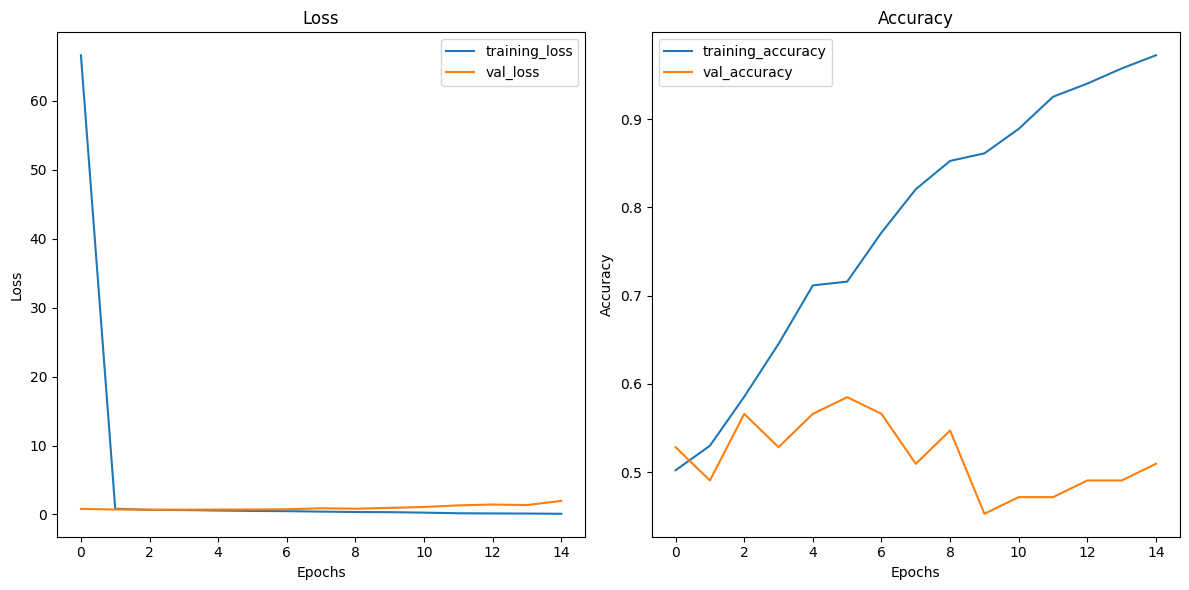

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss and accuracy curves in a single horizontal frame
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(history)

In [ ]:
# Define a function to evaluate the model
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Predictions on training, validation, and testing data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Convert predictions to class labels
    y_train_pred_classes = np.round(y_train_pred).astype(int)
    y_test_pred_classes = np.round(y_test_pred).astype(int)

    # Compute evaluation metrics
    train_accuracy = accuracy_score(y_train, y_train_pred_classes)
    test_accuracy = accuracy_score(y_test, y_test_pred_classes)

    train_precision = precision_score(y_train, y_train_pred_classes, average='weighted')
    test_precision = precision_score(y_test, y_test_pred_classes, average='weighted')

    train_recall = recall_score(y_train, y_train_pred_classes, average='weighted')
    test_recall = recall_score(y_test, y_test_pred_classes, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred_classes, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred_classes, average='weighted')

    train_conf_matrix = confusion_matrix(y_train, y_train_pred_classes)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

    # Print evaluation metrics
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)

    print("Training Precision:", train_precision)
    print("Testing Precision:", test_precision)

    print("Training Recall:", train_recall)
    print("Testing Recall:", test_recall)

    print("Training F1 Score:", train_f1)
    print("Testing F1 Score:", test_f1)

    print("Training Confusion Matrix:")
    print(train_conf_matrix)

    print("Testing Confusion Matrix:")
    print(test_conf_matrix)

# Evaluate the model
evaluate_model(model, x_train, y_train, x_test, y_test)

2/2 [==============================] - 1s 491ms/step
Training Accuracy: 0.9957264957264957
Testing Accuracy: 0.5094339622641509
Training Precision: 0.995761960492251
Testing Precision: 0.507355756084222
Training Recall: 0.9957264957264957
Testing Recall: 0.5094339622641509
Training F1 Score: 0.9957260271405008
Testing F1 Score: 0.5076718716113641
Training Confusion Matrix:
[[227   2]
 [  0 239]]
Testing Confusion Matrix:
[[11 14]
 [12 16]]


In [ ]:
model.save("/content/drive/MyDrive/BreastCancer/models/cnn.h5")

1/1 [==============================] - 0s 429ms/step


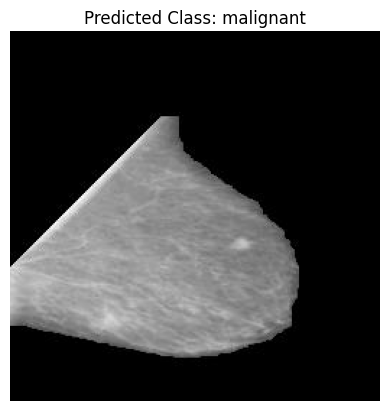

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/content/drive/MyDrive/BreastCancer/models/mobilenet.h5")

# Load and preprocess the image
image_path = "/content/drive/MyDrive/BreastCancer/malignant_sample.jpg"  # Replace with the path to your image
image = Image.open(image_path)
image = image.resize((256, 256))  # Resize the image to match the input size of the model
image_array = np.array(image) / 255.0  # Normalize pixel values to range [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Perform prediction
predictions = model.predict(image_array)

# Convert probabilities to class labels
predicted_class = "malignant" if predictions[0][0] > 0.5 else "benign"

# Display the image and prediction
plt.imshow(image)
plt.title("Predicted Class: " + predicted_class)
plt.axis("off")
plt.show()
